### 1. Sekcja odczytywania danych, określania typów danych cech.

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import matplotlib.pyplot as plt




#Dla każdej cechy określ jej typ danych.
dtypes = { "Make": "category",
          "Model":"category",
          "Vehicle Class":"category",
          "Engine Size(L)":"float",
          "Cylinders":"category",
          "Transmission":"category",
          "Fuel Type":"category",
          "Fuel Consumption City (L/100 km)":np.float64,
          "Fuel Consumption Hwy (L/100 km)":np.float64,
          "Fuel Consumption Comb (L/100 km)":np.float64,
          "Fuel Consumption Comb (mpg)":np.float64,
          "CO2 Emissions(g/km)":np.float64}

Dataset = pd.read_csv("CO2Emission.csv", 
                      sep=';', dtype = dtypes, decimal = ",") #Wczytaj plik z danymi.

n_rows:int  = Dataset.shape[0] #Znajdź liczbę wierszy.


target_var: str = "CO2 Emissions(g/km)"
target_var_discr: str = "CO2 Emissions(g/km)_disc"

target_var_str: str = "CO2 Emissions(g/km)_str"

str_labels = ['Niskie','Średnie','Wysokie']


#Take the target variable column and  change its dimension to 2.
target_var_col = Dataset[target_var].to_numpy().reshape(-1,1)




### 2. Sekcja statystyki opisowej zmiennych kategorycznych

### Częstość występowania  unikatowych klas dla danej zmiennej.

             Make  count  Make_coded
0           ACURA     72           1
1            AUDI    286           2
2             BMW    527           3
3           BUICK    103           4
4        CADILLAC    158           5
5       CHEVROLET    588           6
6        CHRYSLER     88           7
7           DODGE    246           8
8            FIAT     73           9
9            FORD    628          10
10            GMC    328          11
11          HONDA    214          12
12        HYUNDAI    210          13
13       INFINITI    108          14
14         JAGUAR    160          15
15           JEEP    251          16
16            KIA    231          17
17     LAND ROVER     85          18
18          LEXUS    178          19
19        LINCOLN     96          20
20          MAZDA    180          21
21  MERCEDES-BENZ    419          22
22           MINI    204          23
23     MITSUBISHI     95          24
24         NISSAN    259          25
25          Other    334          26
2

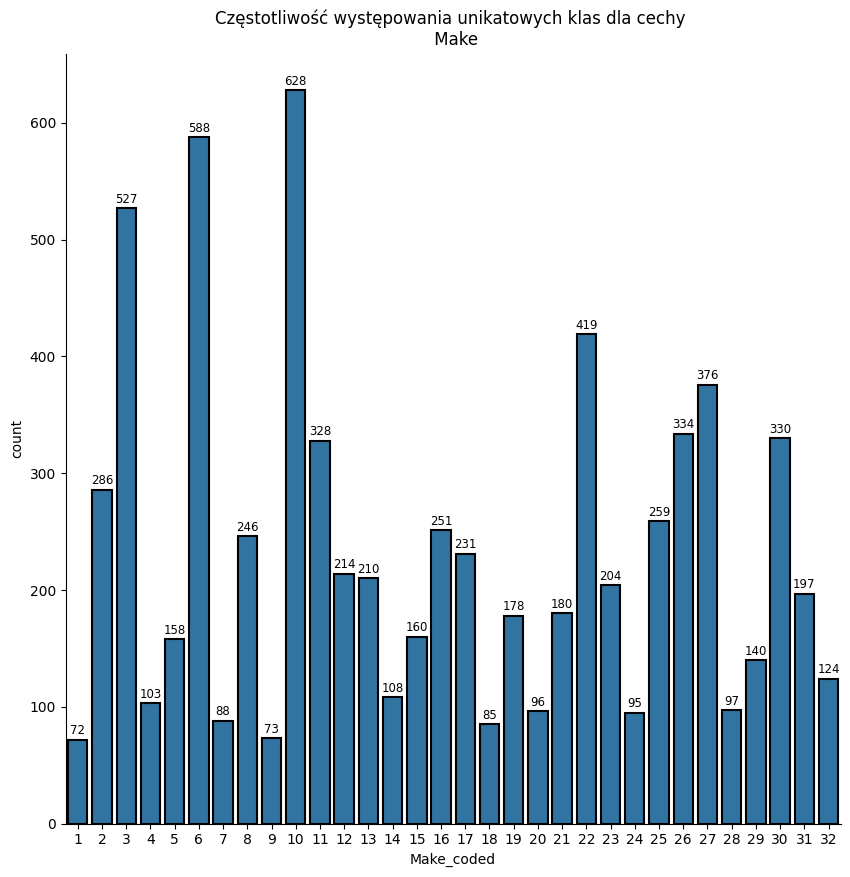

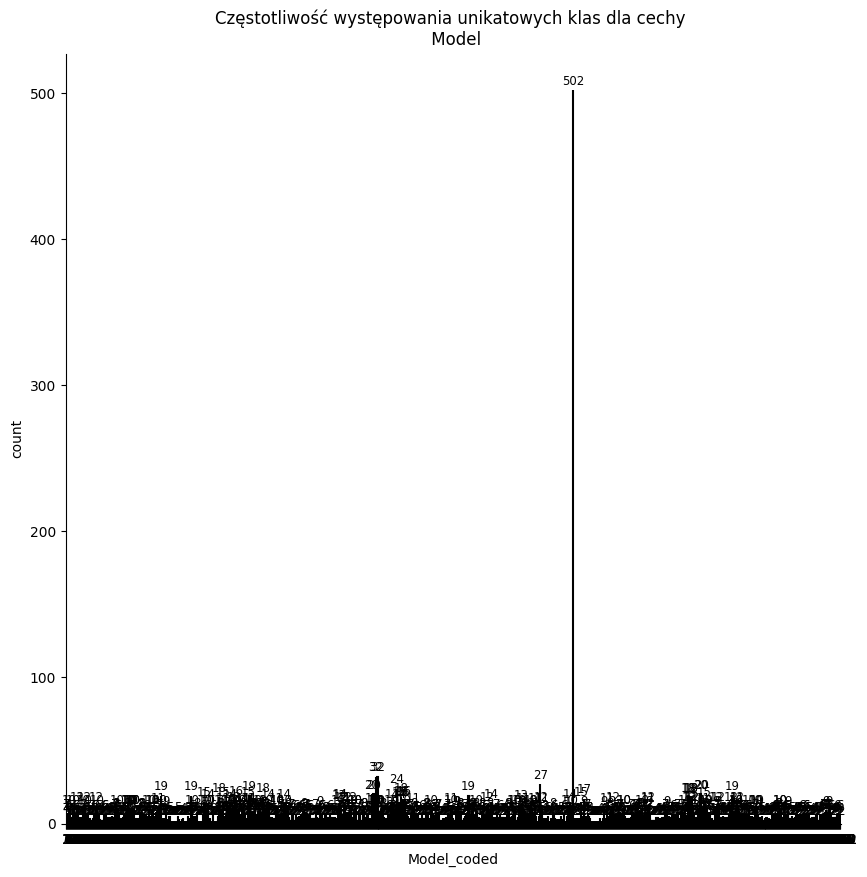

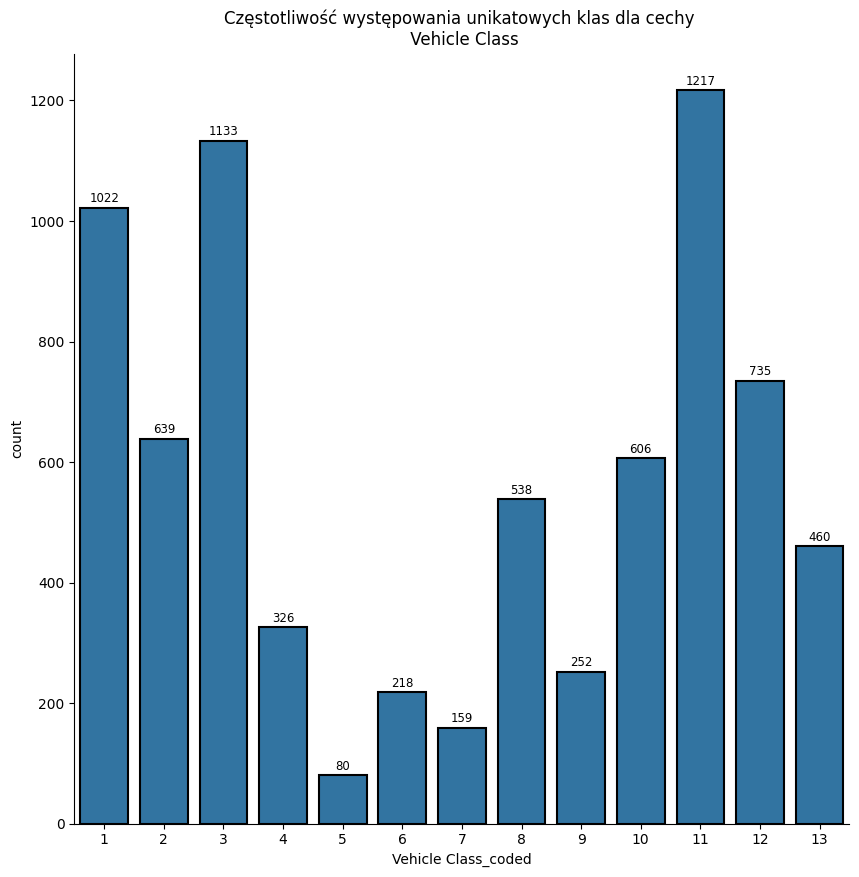

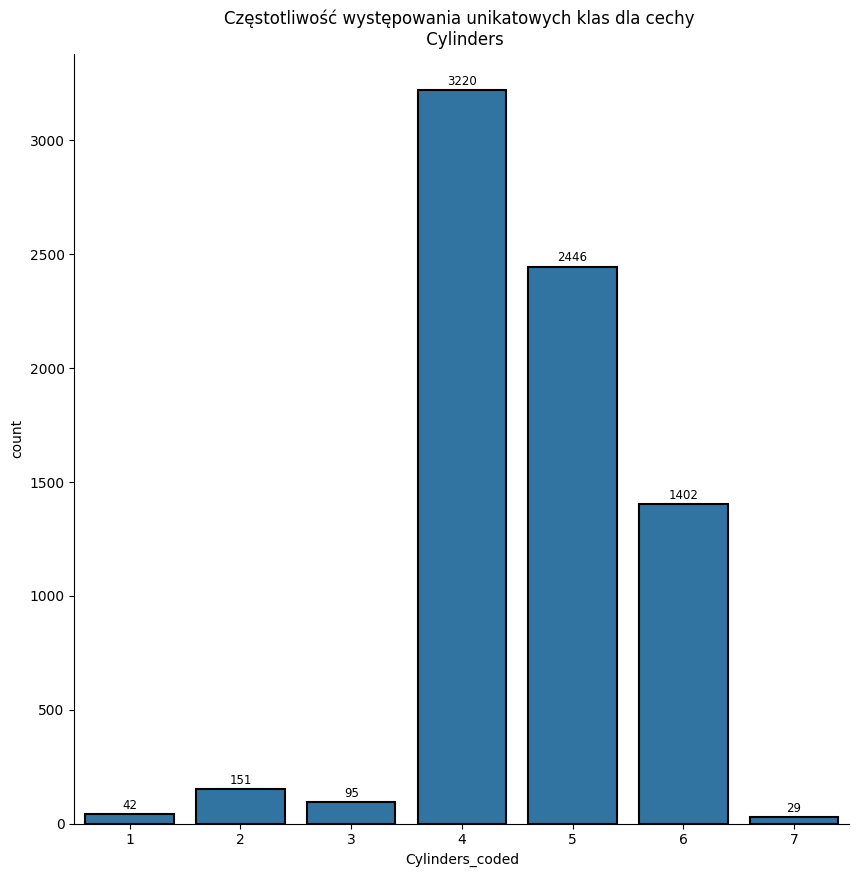

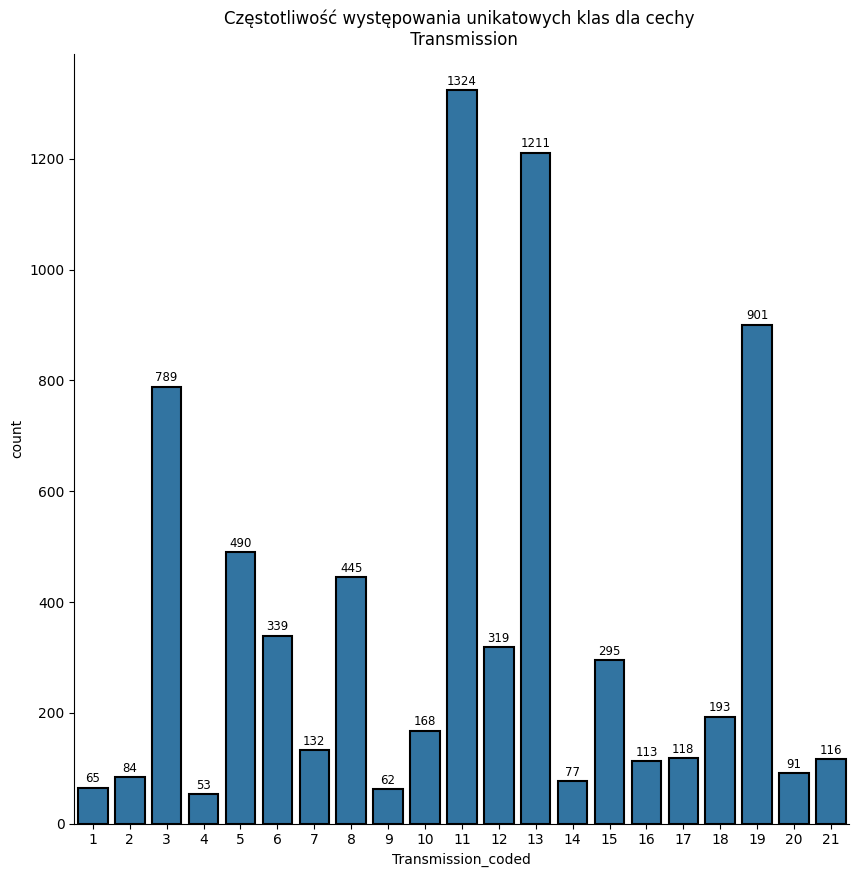

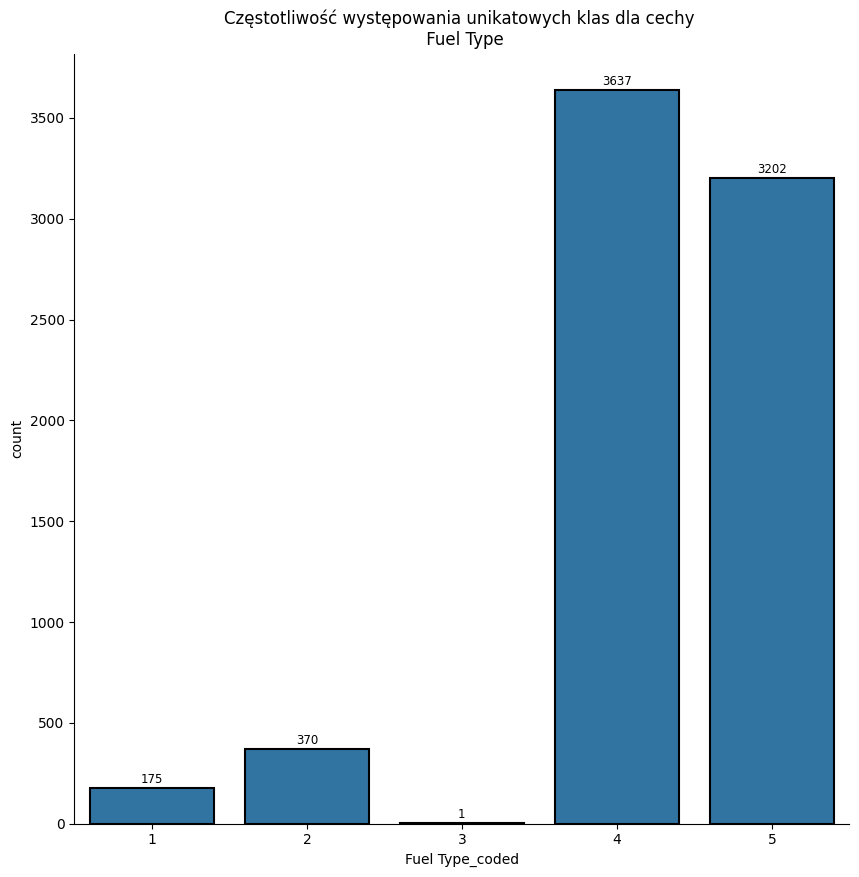

In [4]:

def CreateBarPlot(Data:pd.DataFrame,  CatFeature:str, code: bool = True) -> None:
    """"Funkcja rysująca wykres kolumnowy. Data jest to dwucechowa ramka danych z dwoma cechami:
    pierwsza z nich to CatFeature, druga - "count"."""
    

    if code == True:
        axes = sns.barplot(data = Data, 
        x = f"{CatFeature}_coded", y = "count", linewidth = 1.5, edgecolor = "black",)
    else:
        axes = sns.barplot(data = Data, 
        x = f"{CatFeature}", y = "count", linewidth = 1.5, edgecolor = "black",)



  

    axes.set_title(f"Częstotliwość występowania unikatowych klas dla cechy \n {CatFeature}") #Ustaw ładny tytuł
    

    axes.spines[["top","right"]].set_visible(False) #Skasuj górna i prawą oś.
    
    axes.bar_label(axes.containers[0], 
                   labels = Data["count"], 
                   fontsize = 8.5, 
                   padding = 1.75)

    

CatFeatures: list[str] = Dataset.select_dtypes(include = "category").columns #Znajdź listę wszystkich cech kategorycznych



for CatFeature in CatFeatures:
    
    CatFeature_Figure = plt.figure(num = CatFeature,
                                   figsize = (10, 10)) #Stwórz okienko, na którym umieścimy wykres dla danej kategorii.
    CatFeature_axes = CatFeature_Figure.add_subplot() #Dodaj podwykres
    

    HistogramSet = Dataset[CatFeature].value_counts(sort = False).reset_index() #Zlicz częstości występowania klas.

    #Policz próg częstotliowści poniżej którego klasa będzie interpretowana jako "bardzo rzadka".
    #Tym progiem jest kwantyl rzędu 0.25 dla liczb częstości występowania.
    frequent_threshold: float = np.quantile(HistogramSet['count'], q = 0.25) 



    #Aggregate the rarest class (that is - those whose frequency is less than frequen_threshold)

    HistogramSet[CatFeature] = HistogramSet.apply(func = 
                                         lambda x: "Other" if x["count"] < frequent_threshold else  x[CatFeature], 
                                         axis = 1)
    


    #The sum functions effectively deals with the class "Other". For other classes, the result of sum
    #function is just the frequency of a one class.
    HistogramSet = HistogramSet.groupby(by = CatFeature, 
                                        as_index = False).agg(func = {"count":"sum"})
    

    HistogramSet[f"{CatFeature}_coded"] = np.arange(1, len(HistogramSet)+1, step = 1, dtype = np.int16)
    print(HistogramSet)
    CreateBarPlot(HistogramSet, CatFeature)



## 3. Pierwsze wnioski, jakie można wysunąć:


### Zmienna make może zostać skasowana. Nie jest ona dobrą zmienną, którą można uwzględnić w modela, z powodu ogromnej liczby unikatowych klas (ponad 2000), co czyni ją niemalże zmienną identyfikującą.

### Obserwacja, której typ paliwa to 3, może zostać pominięta. Występuje nienormalnie rzadko.

### 4. Liczba unikatowych klas każdej cechy kategorycznej, kwartyl rzędu 25, liczba outliersów.


In [5]:
UniQuanOut_Comparison = pd.DataFrame(columns = CatFeatures, index = ['unique_classes','Ratio','25th-quartile','n_outliers','n_outliers/n_total'])

for CatFeature in CatFeatures:
    CatHistogram:pd.DataFrame = Dataset[CatFeature].value_counts(sort = False).reset_index()


    n_uniqueclass:int = CatHistogram.shape[0]
    frequent_threshold:float = round(CatHistogram["count"].quantile(q = 0.25),4)
    n_uniqueclass:int = CatHistogram.shape[0]

    n_uniqueclass_ratio:float = 100*round(n_uniqueclass/Dataset.shape[0],4)


    n_outliers:int = (CatHistogram['count']<=frequent_threshold).sum()
    n_outliers_ratio:float = 100*round(n_outliers/n_uniqueclass, 4)

    UniQuanOut_Comparison.loc[:, CatFeature] = [n_uniqueclass, n_uniqueclass_ratio, frequent_threshold, n_outliers, n_outliers_ratio]

print(UniQuanOut_Comparison)


                     Make  Model Vehicle Class Cylinders Transmission  \
unique_classes         42   2053            16         8           27   
Ratio                0.57   27.8          0.22      0.11         0.37   
25th-quartile       63.75    2.0         79.25      38.0         46.0   
n_outliers             11   1107             4         2            7   
n_outliers/n_total  26.19  53.92          25.0      25.0        25.93   

                   Fuel Type  
unique_classes             5  
Ratio                   0.07  
25th-quartile          175.0  
n_outliers                 2  
n_outliers/n_total      40.0  


### Kasujemy zmienną Model oraz obserwację, której cecha "Fuel Type" wynosi N

In [6]:
Dataset.drop(columns = ["Model"], inplace = True)
Dataset.query(expr = ' `Fuel Type` != "N"')


,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33.0,196.0
1,ACURA,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29.0,221.0
2,ACURA,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48.0,136.0
3,ACURA,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25.0,255.0
4,ACURA,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27.0,244.0
...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30.0,219.0
7381,VOLVO,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29.0,232.0
7382,VOLVO,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27.0,240.0
7383,VOLVO,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29.0,232.0


### 5. Cechy numeryczne ciągłe.

### Badanie zależności poziomu emisji dwutlenku węgla w zależności od wielkości spalania paliwa na autostradzie i w mieście dla różnych typów paliwa.


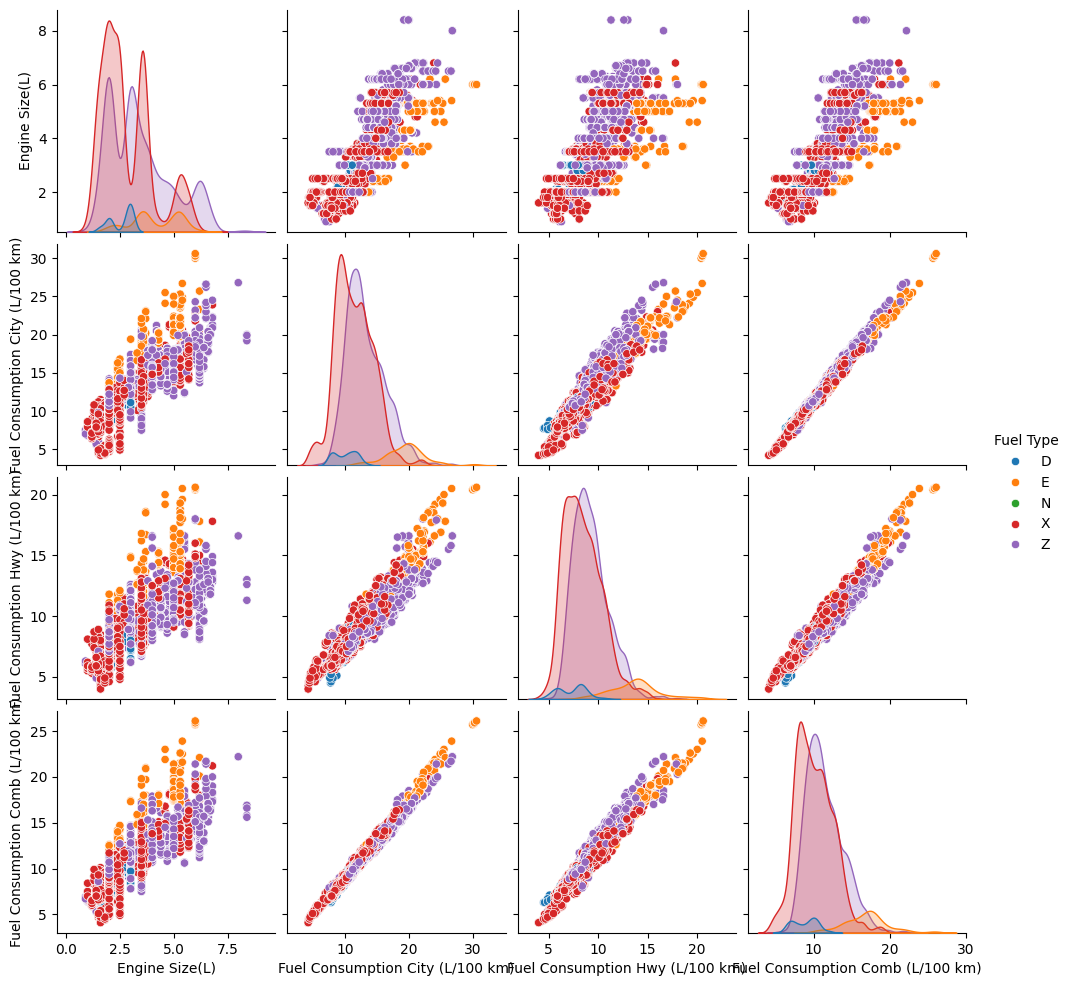

In [7]:
import seaborn as sns



ContFeatures = ["Engine Size(L)",
"Fuel Consumption City (L/100 km)",
"Fuel Consumption Hwy (L/100 km)",
"Fuel Consumption Comb (L/100 km)"]



#Utwórz wykres parowy. (to znaczy - dla par zmiennych ciągłych) warunkowy ze względu na typ paliwa.
sns.pairplot(data = Dataset, vars = ContFeatures, hue = "Fuel Type")



### 6. Dyskretyzacja zmiennej docelowej.

In [8]:

discretized_feature = pd.cut(x = Dataset[target_var], bins = [-float('inf'),150, 255, float("inf")], labels = [i for i in range(len(str_labels))])


Dataset[target_var_discr] = discretized_feature

Dataset[target_var_str] = Dataset[target_var_discr].map(arg = {i:str_labels[i] for i in range(len(str_labels))})

### 7. Warunkowe wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych.

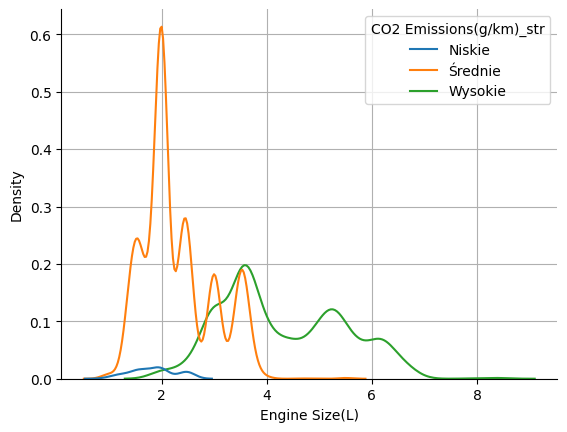

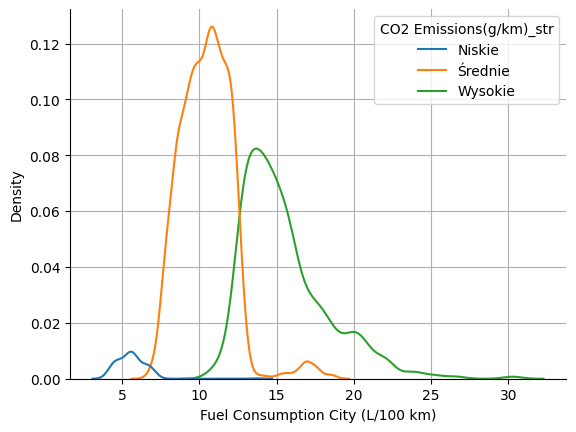

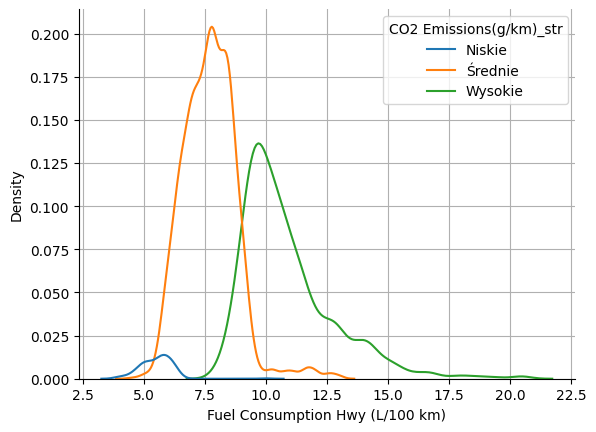

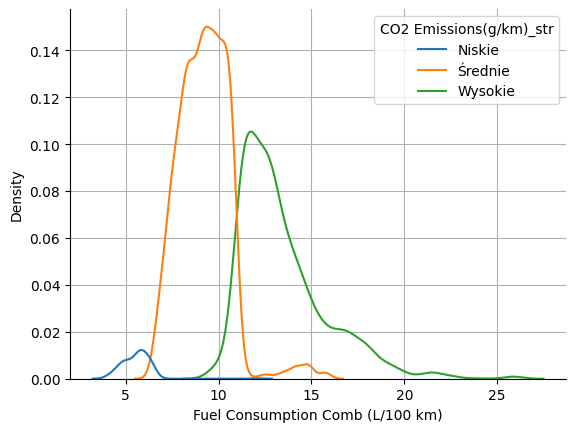

In [9]:
def StwórzWykresKDE(Dataset:pd.DataFrame, ContFeature:str, condfeature:str | None = None) -> plt.axes:
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.kdeplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres warunkowy.

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)

    return osie


for ContFeature in ContFeatures:
    
    StwórzWykresKDE(Dataset, ContFeature, condfeature = target_var_str)


### 8. Wykresy gęstości prawdopodobieństwa cia zmiennych ciągłych

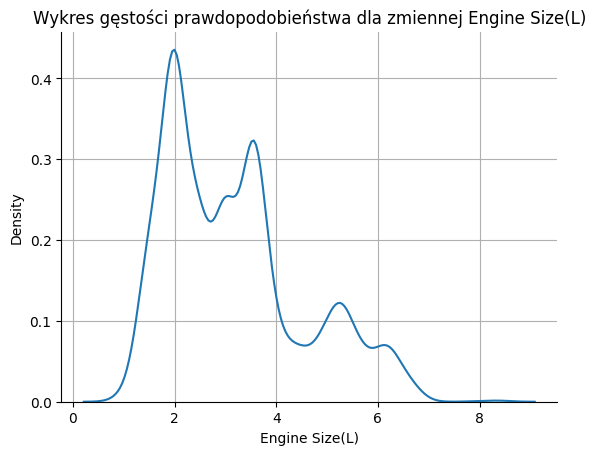

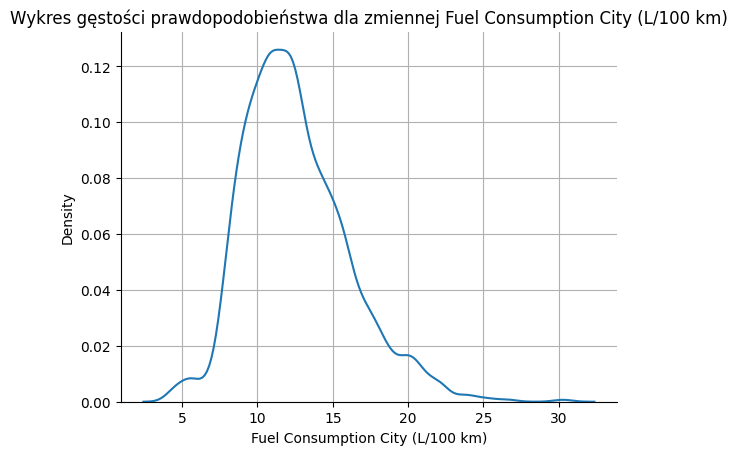

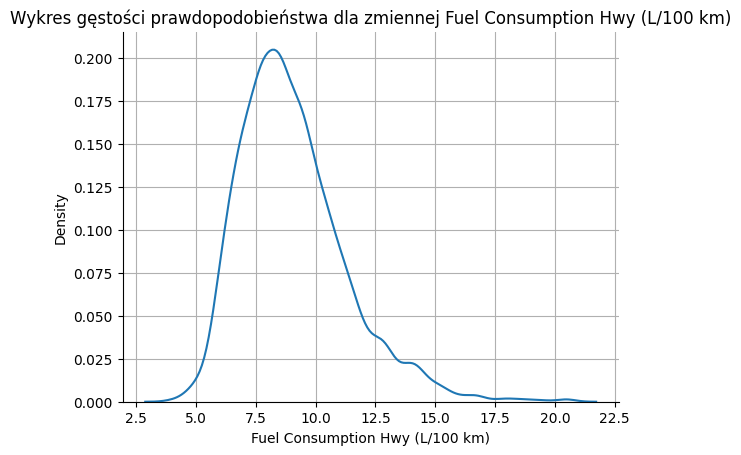

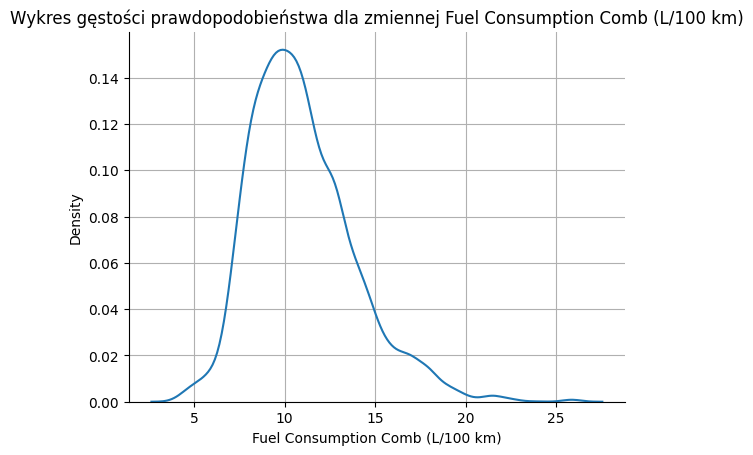

In [10]:
for ContFeature in ContFeatures:
    
    axes = StwórzWykresKDE(Dataset, ContFeature)
    axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {ContFeature}")

### Dochodzimy do wniosku, że wszystkie cztery powyższe cechy ciągłe są bardzo dobrze dyskryminującę. Wykresy gęstości prawdopdoobieństwa dla każdej z cech ciągłych są praktycznie rozłączne, nie nachodzą na siebie.

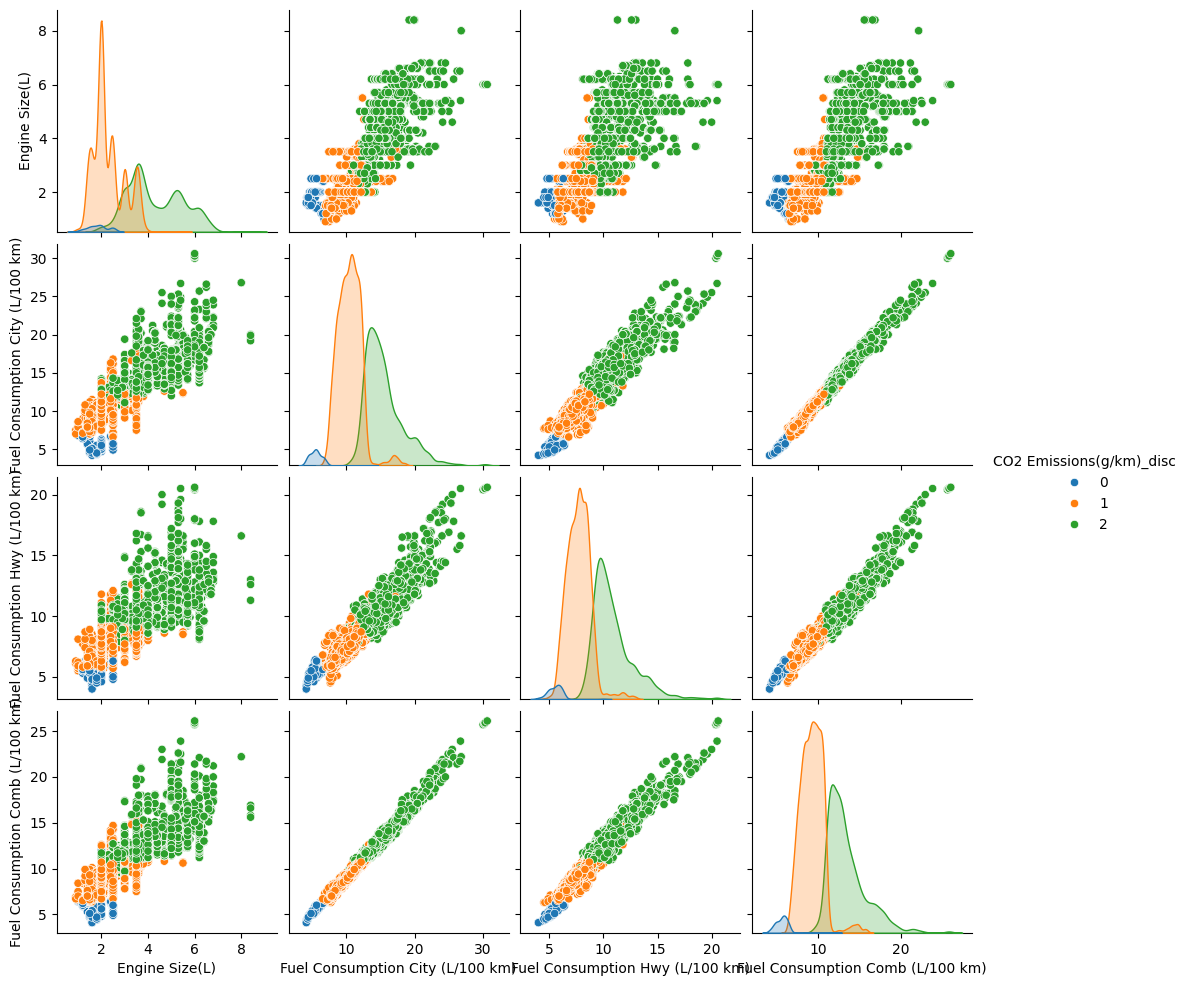

In [11]:
#Teraz stwórz wykres parowy warunkowy ze względu na dyskretną wartość zmiennej docelowej.
sns.pairplot(data = Dataset, vars = ContFeatures , hue = target_var_discr)


### 7. Wykresy pudełkowe dla zmiennych ciągłych.

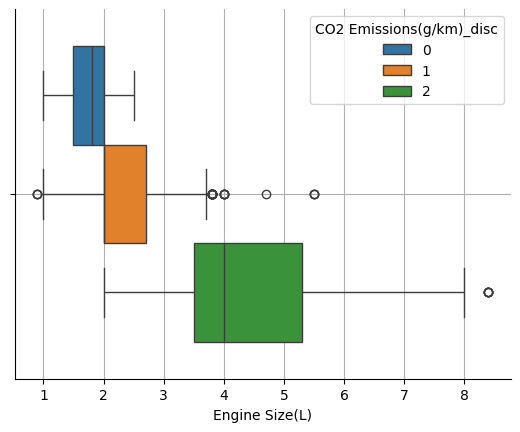

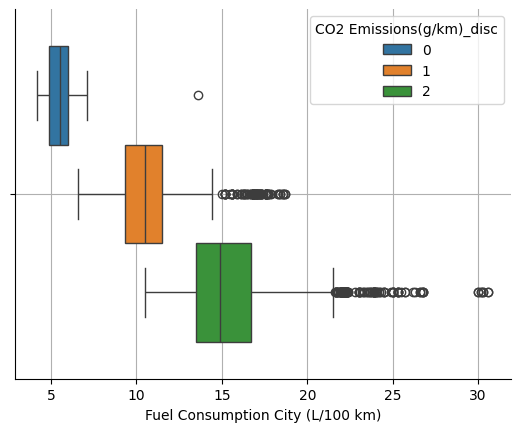

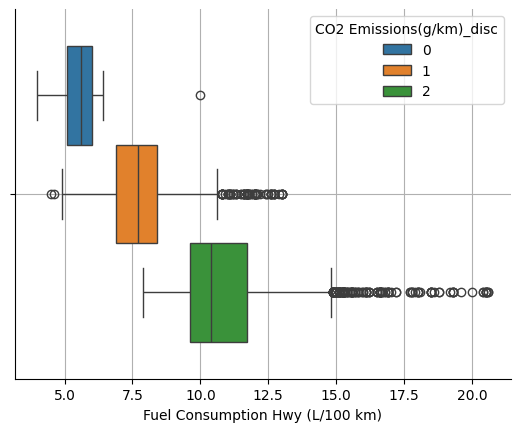

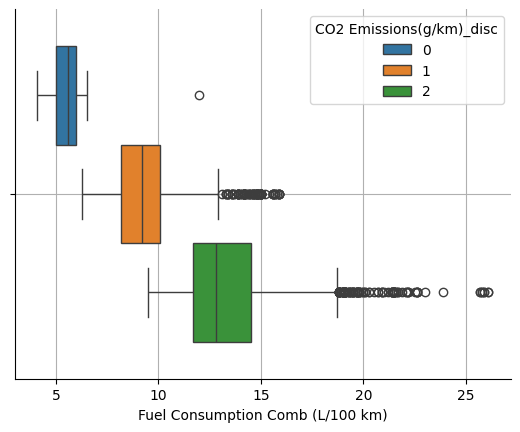

In [12]:
def StwórzWykresPudełkowy(Dataset:pd.DataFrame, ContFeature:str, condfeature:str):
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.boxplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres pudełkowy..

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)


for ContFeature in ContFeatures:
    
    StwórzWykresPudełkowy(Dataset, ContFeature, target_var_discr)

### Powyższe wykresy pudełkowe utwierdzają nas w przekoniu, że te zmienne idealnie spełniają wymagania na bycie predyktorem.

In [13]:


Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type','Fuel Consumption City (L/100 km)']


print(Predictors)


['Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)']


### 8. Kodowanei zmiennych kategorycznych.

In [80]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#Określ zestaw cech predykcyjnych.
X = Dataset[Predictors]
#Określ cechę celu. Tę kolumne przekształć do tablicy numpy wymiary (n_samples, 1).
y = Dataset[target_var_discr].to_numpy().reshape(-1,1)

#Zdefiniuj transformator. Jest on oparty na koderze OneHotEncoder(). Do przekształcenia bierzemy tylko kolumny kategoryczne. Pozostałe kolumny (zmienne ciągłe) są przekazywane 
#do wyjściowej ramki zmiennych predykcyjnych bez zmian.
cat_col_transformer = ColumnTransformer(transformers = 
                                        [('cat',OneHotEncoder(sparse_output = False), make_column_selector(dtype_include=['category','object']))],
                                        remainder = "passthrough",)

#Przekształć zmienną X za pomocą określonego wyżej transformatora.
X_coded = cat_col_transformer.fit_transform(X = X)



[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


In [173]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Zdefiniuj pierwszy model
Model = DecisionTreeClassifier(criterion = "gini", 
                                    splitter = "best", min_samples_split = 10,)


#Podziel zbiór  na testowy i treningowy
X_coded_train, X_coded_test, y_train, y_test = train_test_split(X_coded, y, 
                                                                train_size = 0.8, test_size = 0.2, random_state = 1 )


#Wytrenuj model.
Model.fit(X = X_coded_train, 
          y = y_train)

#A następnie zbadaj modelu efektywność, obliczająć metrykę o nazwie dokładność.
Accuracy = Model.score(X = X_coded_test, 
            y = y_test)

print(Accuracy)


#Walidacja krzyżowa.

#Określ liczbę iteracji:
cv_n = 25
iterations = np.arange(1, cv_n+1, dtype = np.int16)

CV = cross_validate(estimator = Model, X = X_coded, y = y, scoring = "accuracy", cv = cv_n)
scores = CV['test_score']


0.967501692620176


### Zaprezentuj wyniki dla drzewka klasyfikacyjnego na wykresie liniowym oraz na histogramie oraz na wykresie pudełkowym.

Text(0.5, 1.0, 'Wykres rozrzutu wartości dokładności dla Drzewka Decyzyjnego')

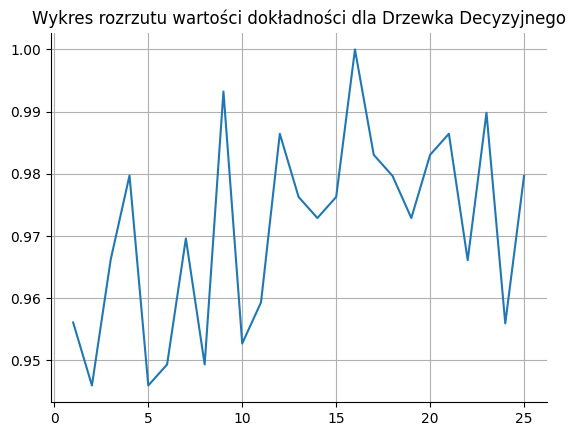

In [174]:


TreeLineAxes = sns.lineplot(x = iterations,  y = scores, markers = 'dotted')

TreeLineAxes.grid(True)
TreeLineAxes.spines[['top','right']].set_visible(False)

TreeLineAxes.set_title("Wykres rozrzutu wartości dokładności dla Drzewka Decyzyjnego")



Text(0.5, 1.0, 'Wykres pudełkowy wartości dokładności dla Drzewka Decyzyjnego')

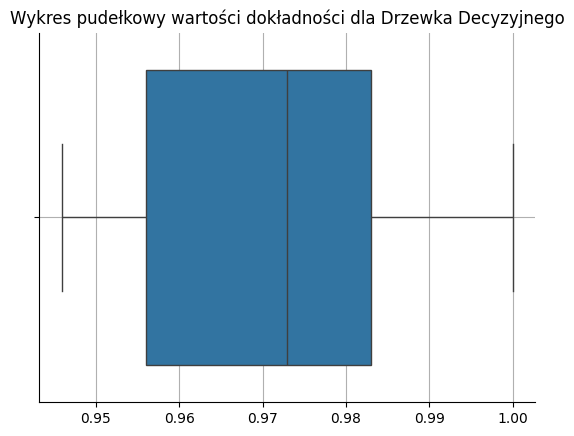

In [175]:
TreeBoxAxes = sns.boxplot(x = scores)

TreeBoxAxes.spines[['top','right']].set_visible(False)
TreeBoxAxes.grid(True)


TreeBoxAxes.set_title(f"Wykres pudełkowy wartości dokładności dla Drzewka Decyzyjnego")

Text(0.5, 1.0, 'Histogram wartości dokładności dla Drzewka Decyzyjnego')

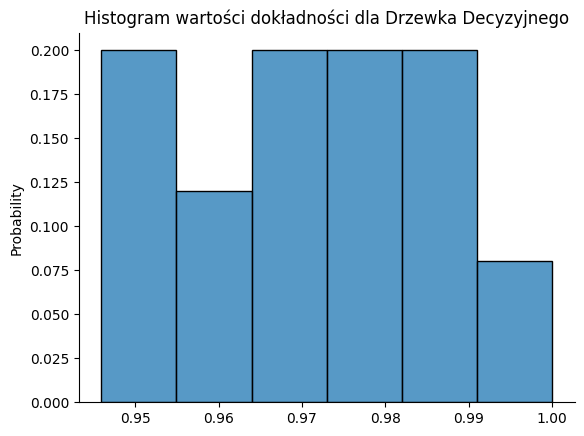

In [177]:
TreeHistAxes = sns.histplot(x = scores, stat = "probability")


TreeHistAxes.spines[['top','right']].set_visible(False)

TreeHistAxes.set_title(f"Histogram wartości dokładności dla Drzewka Decyzyjnego")